# S. cerevisiae Transcriptome


## Section 1: Visualizing the network

In [81]:
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

g = nx.read_edgelist(
    "/Users/katherinesong/Desktop/compsci/networks_scratch/yeast.csv/edgess.csv", 
    delimiter=",", 
    create_using=nx.DiGraph, 
    data=(("regulation", int),)
)
print("Info", g)

Info DiGraph with 690 nodes and 1094 edges


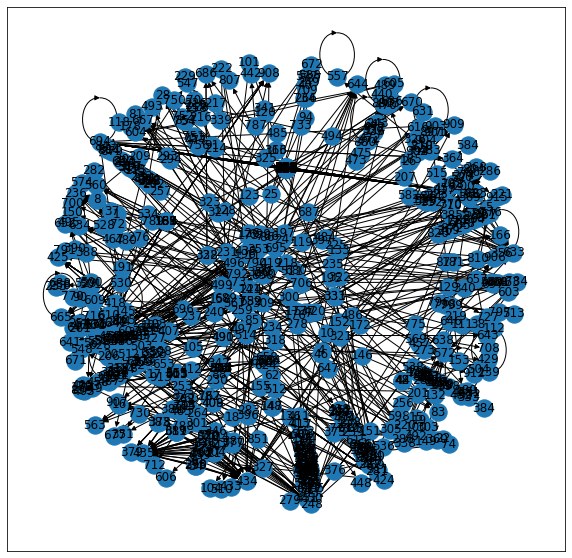

In [82]:
nodelist = list(g.nodes)
A = nx.to_numpy_array(g, nodelist=nodelist)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(g)

In [83]:
from graspologic.utils import is_fully_connected

is_fully_connected(A)

False

In [84]:
from graspologic.utils import largest_connected_component
A = largest_connected_component(A)
g = nx.from_numpy_matrix(A, parallel_edges=False, create_using=nx.DiGraph)

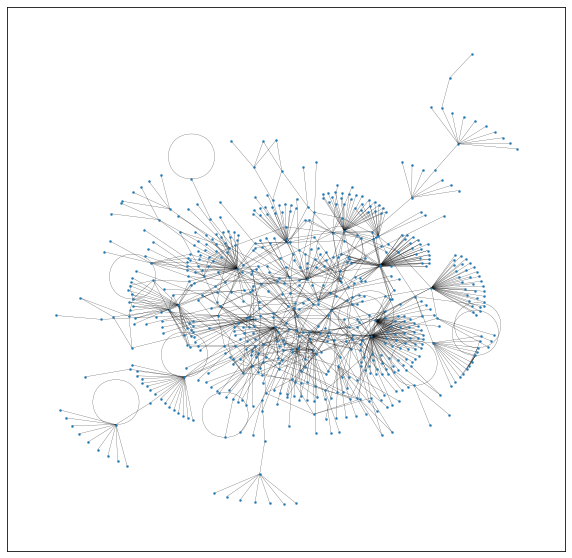

In [89]:
pos = nx.kamada_kawai_layout(g, scale=1.5) 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(g, pos=pos, ax=ax, with_labels=False, node_size=5, width=0.2, linewidths=0.2, arrows=None)

<AxesSubplot:>

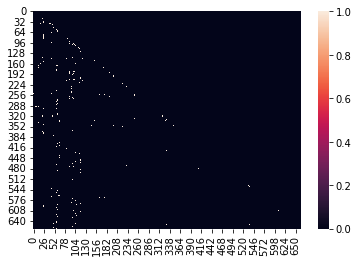

In [86]:
sns.heatmap(A) 

...


<AxesSubplot:>

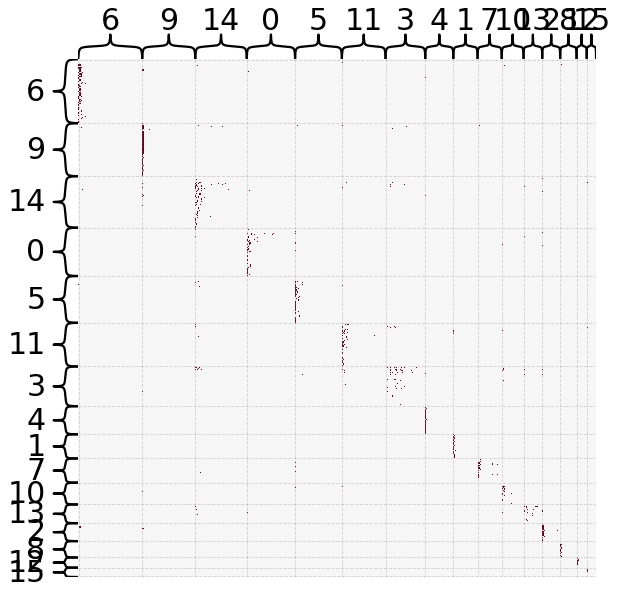

In [87]:
from graspologic.utils import binarize

g = nx.from_numpy_matrix(A, parallel_edges=False, create_using=nx.Graph)
nodelist = list(g.nodes)

from graspologic.partition import leiden
from graspologic.plot import heatmap

partition_map = leiden(g, trials=100)
print("...")
labels = np.vectorize(partition_map.get)(nodelist)
heatmap(A, inner_hier_labels=labels, sort_nodes=True, cbar=False)

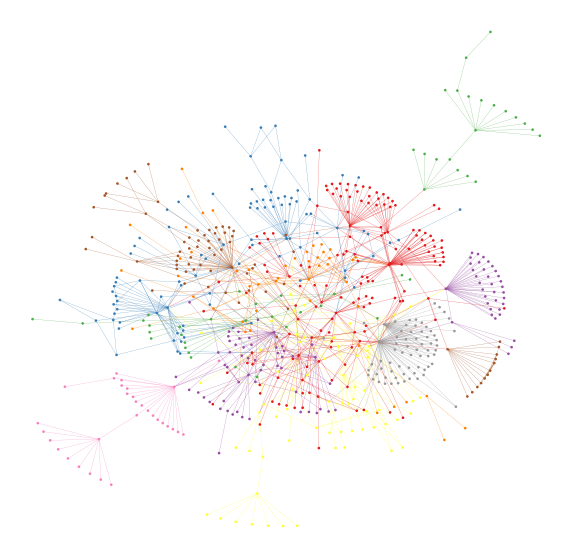

In [90]:
from graspologic.plot import networkplot

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

ax = networkplot(
    A,
    x=xs,
    y=ys,
    node_alpha=1.0,
    edge_alpha=1.0,
    edge_linewidth=0.2,
    node_hue=labels,
    node_kws=dict(s=7, linewidth=0),
)

_ = ax.axis('off')

# section 2: measuring centrality. 
I wanted to see which nodes (RNA snippets/operons) had the most interactions with other nodes.

In [72]:
def map_to_nodes(node_map):
    node_map.setdefault(0)
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(nodelist))

degrees = map_to_nodes(dict(g.degree())) #returns list
in_degrees = A.sum(axis=0) 
out_degrees = A.sum(axis=1) #they're the same for undirected networks
max_degrees = max(degrees)

print(max(in_degrees))
print(max(out_degrees))

72.0
13.0


In [73]:
most_connected_indices = [i for i, x in enumerate(degrees) if x == max_degrees]
print(most_connected_indices, max_degrees)
print("node with most connections: ", nodelist[most_connected_indices[0]])

[53] 73
node with most connections:  53


In [ ]:
eigenvalues = map_to_nodes(dict(nx.eigenvector_centrality(g)))
max_eigen = max(eigenvalues)
max_eigen_indices = [i for i, x in enumerate(eigenvalues) if x == max_eigen]
print(max_eigen_indices)
print("node with maximum eigenvalue: ", nodelist[max_eigen_indices[0]])
#261,HSF1

[92]
node with maximum eigenvalue:  261


In [ ]:
#pagerank
pagerank_dict = nx.pagerank(g, max_iter=100)
np.vectorize(pagerank_dict.get)(nodelist)

max_pgrank = max(pagerank_dict)
max_pgrank_indices = [i for i, y in enumerate(pagerank_dict) if y == max_pgrank]
print(max_pgrank_indices)
print("node with maximum pgrank: ", nodelist[max_pgrank_indices[0]])
#99,CLN1

[122]
node with maximum pgrank:  99


In [ ]:
betweenness_dict = nx.betweenness_centrality(g, normalized=True)
max_betweenness = max(betweenness_dict)
max_betweenness_indices = [i for i, y in enumerate(betweenness_dict) if y == max_betweenness]
print(max_betweenness_indices)
print("node w max betweenness centrality: ", nodelist[max_betweenness_indices[0]])

#99, CLN1

[122]
node w max betweenness centrality:  99


*This will be the main section, I want to list the top 10 nodes for each centrality measure and see if they match up with actual activity of the transcriptome (I don't expect them to match up since activity also depends on physical conditions, but it could still be interesting)

# section 3: network embedding 
I really just wanted to get a nicer layout but I'm not sure how valid this representation is--  I couldn't figure out how to incorporate the directed graph so ended up with just the X values from ase embed 


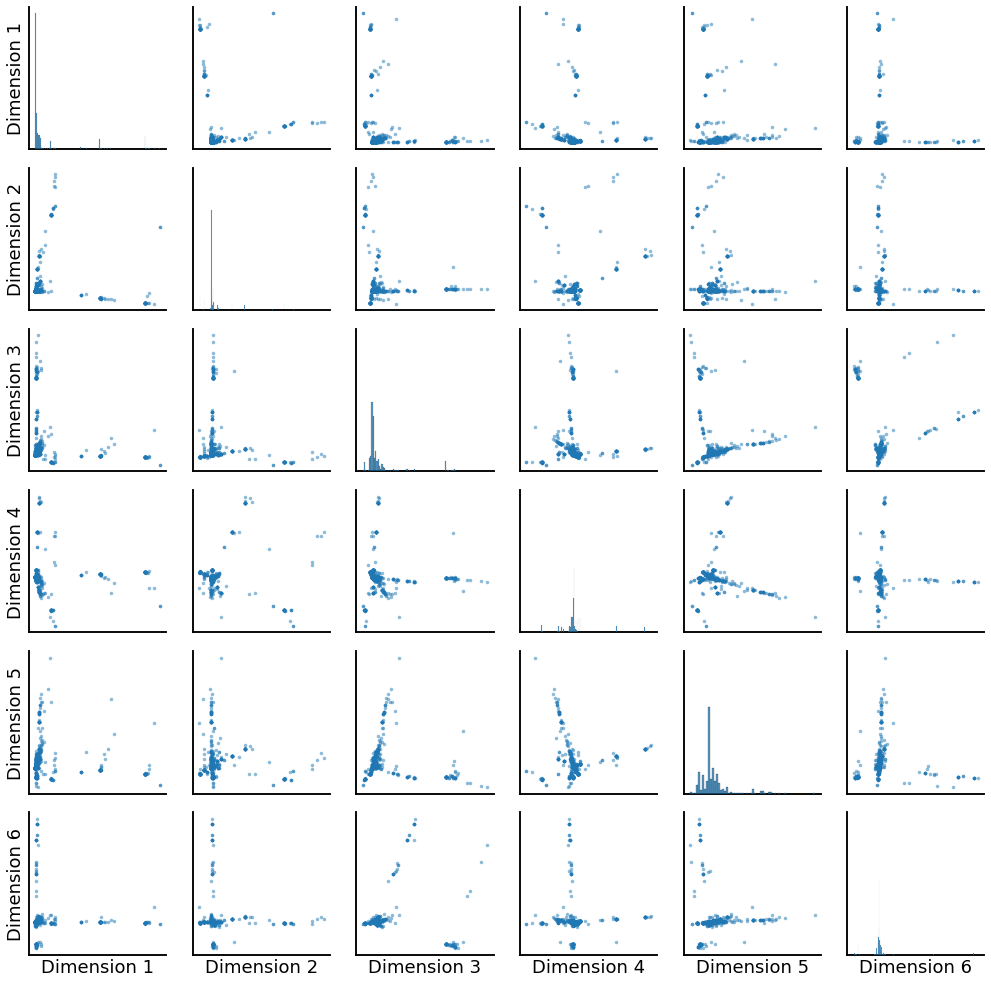

In [50]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()

X, Y = ase.fit_transform(A)

from graspologic.plot import pairplot

pairplot(X, alpha = 0.5)

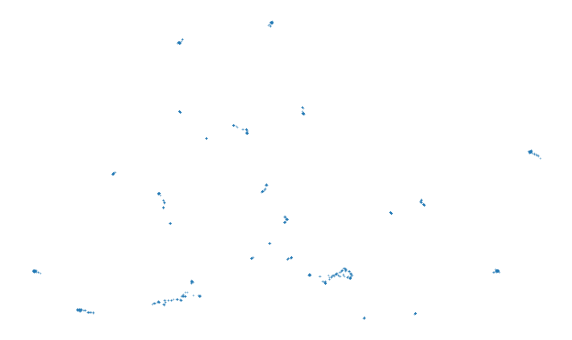

In [51]:
#dimensiomality reduction
from umap import UMAP
umapper = UMAP(metric="manhattan")
umap_ase_embedding =  umapper.fit_transform(X)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(
    x=umap_ase_embedding[:, 0],
    y=umap_ase_embedding[:, 1],
    ax=ax,
    s=3,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

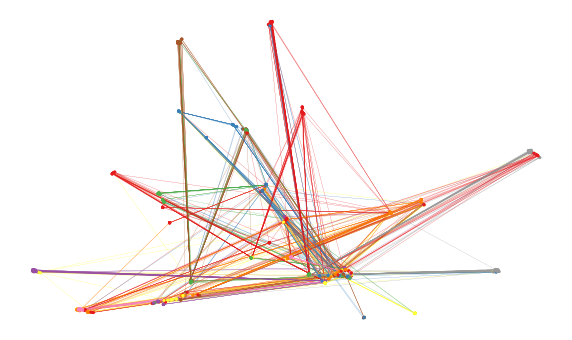

In [53]:
from graspologic.plot import networkplot

ax = networkplot(
    A,
    x=umap_ase_embedding[:, 0],
    y=umap_ase_embedding[:, 1],
    node_alpha=1.0,
    edge_alpha=1.0,
    edge_linewidth=.2,
    node_hue=labels,
    node_kws=dict(s=10, linewidth=0),
    figsize=(10,6)
)

_ = ax.axis('off')